In [111]:
using QuantumOptics
using DiffEqNoiseProcess
using PyPlot
using LsqFit
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase
using Optim
using JLD2
using BenchmarkTools
include("HenryLib.jl")

make_white_noise (generic function with 1 method)

In [28]:
λrel = 0.9
Nspin = 100
fockmax=4
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz

fb, sb, bases, a, Sx, Sy, Sz = make_operators(fockmax, Nspin)

λc = 1 / 2 * sqrt((Δc^2 + κ^2) / Δc * ωz)
λ = λrel * λc

αinit=0.
φinit=0.

if λrel > 1.0
    θ_α = atan(-κ/Δc)
    Szinit = -ωz*Nspin/(8*λ^2)*sqrt(Δc^2 + κ^2)/cos(θ_α)
    Sxinit = sqrt(Nspin^2/4 - Szinit^2)
    φinit=atan(Sxinit/Szinit)
    αinit = 2im*λ/(sqrt(Nspin)*(-1im*Δc-κ))*Sxinit
end

C = sqrt(2 * κ) * a
H0 = Δc * dagger(a) * a + ωz * Sz + 2 * λ * (dagger(a) + a) * Sx / sqrt(Nspin)

ψ0 = tensor(spindown(sb), coherentstate(fb, αinit))# + coherentstate(b,-0.7))
ψ0 = exp(-im * φinit * Sy) * ψ0
ψ0 = normalize!(ψ0)

Ket(dim=505)
  basis: [Spin(50) ⊗ Fock(cutoff=4)]
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [34]:
expect(a, ψ0)

0.0 + 0.0im

In [4]:
seed = Int(round(mod(time()*300,1000)))

280

In [8]:
num_runs = 15
Nspins = Int.(round.((10).^(LinRange(0.0, log(1000.0)/log(10.0), num_runs)))) 
# Int.((10).^(LinRange(0.0, 10000.0, num_runs)))
exc_times = zeros(num_runs)
avg_PN = zeros(num_runs)
std_PN = zeros(num_runs)
for i in range(1,num_runs)
    exc_times[i] = @elapsed tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run(42, 1.0, Nspin=Nspins[i])
    avg_PN[i] = mean(real(expect(dagger(a)*a, psi_t)[2*div(length(tout), 3):length(tout)]))
    std_PN[i] = std(real(expect(dagger(a)*a, psi_t)[2*div(length(tout), 3):length(tout)]))
    jldsave("SizeScalingRslts.jld2"; Nspins, exc_times, avg_PN, std_PN)
end

Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42Running with seed: 42

In [41]:
seed = 24
λrel = 0.9
κ=2π*30 #MHz
Nspin=100
tmax=500

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrel, κ=κ, tmax=tmax, Nspin=Nspin)

Running with seed: 24

([0.0, 0.10002000400080016, 0.20004000800160032, 0.30006001200240046, 0.40008001600320064, 0.5001000200040008, 0.6001200240048009, 0.7001400280056012, 0.8001600320064013, 0.9001800360072014  …  499.0998199639928, 499.1998399679936, 499.2998599719944, 499.3998799759952, 499.499899979996, 499.5999199839968, 499.6999399879976, 499.7999599919984, 499.8999799959992, 500.0], Ket{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{50//1, Int64}, FockBasis{Int64}}}, Vector{ComplexF64}}[Ket(dim=505)
  basis: [Spin(50) ⊗ Fock(cutoff=4)]
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=505)
  basis: [Spin(50) ⊗ Fock(cutoff=4)]
           -0.0 - 0.0im
           -0.0 + 0.0im
            0.0 + 0.0im
            0.0 - 0.0im
           -0.0 - 0.0im
           -0.0 + 0.0im
            0.0 + 0.0im


In [54]:
function smoothstep(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

smoothstep (generic function with 1 method)

In [113]:
besselk((3-2)/2, 0.0)

Inf

In [123]:
nu = (3-2)/2
gamma(nu)/(2^(nu+1))

0.886226925452758

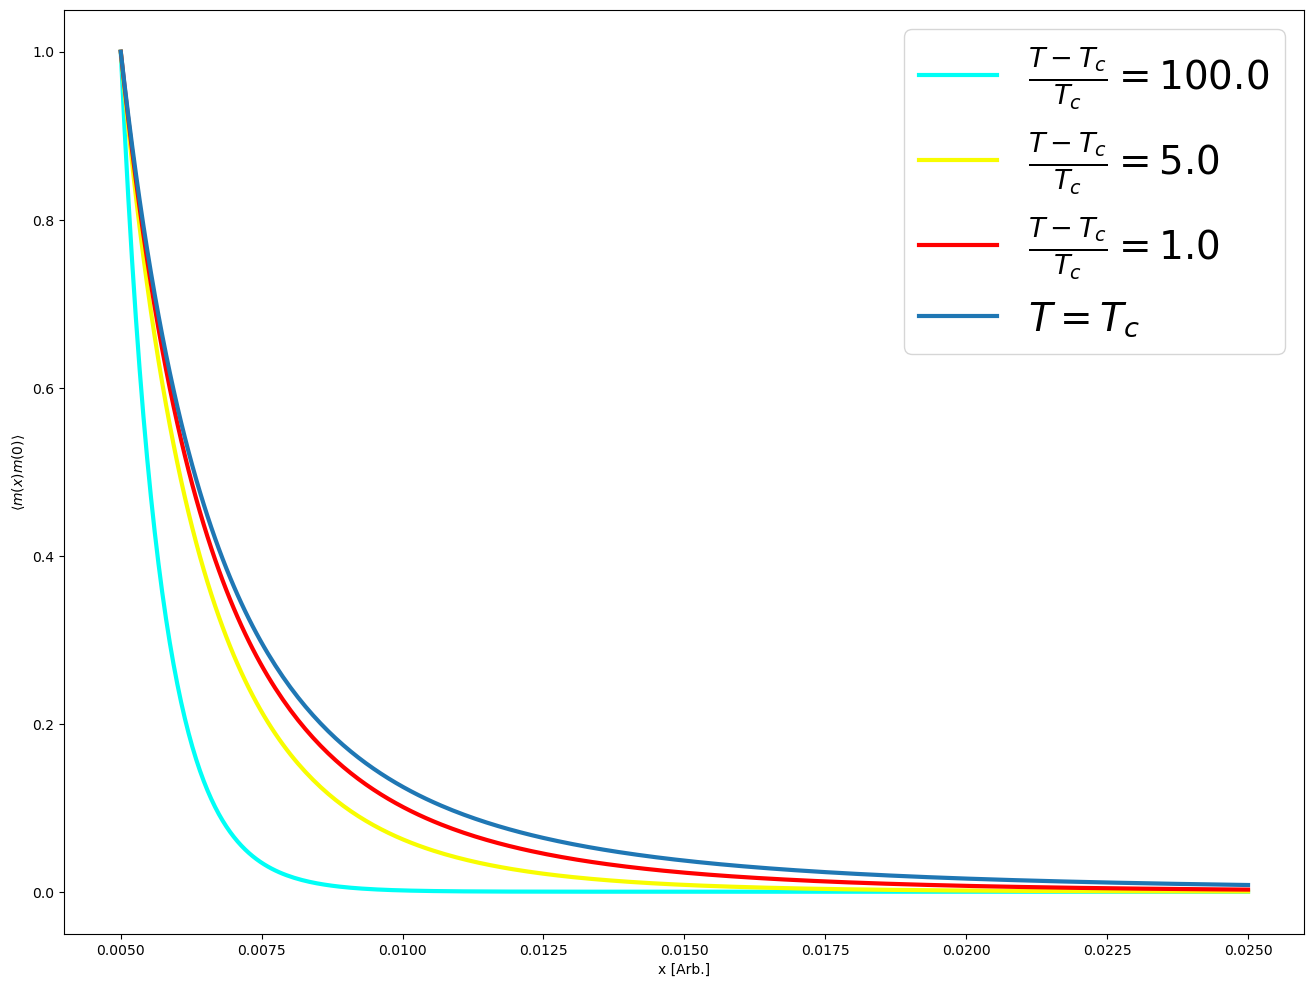

0.001
0.004472135954999579
0.01


In [243]:
xmin = 0.005
x = LinRange(xmin,0.025,300)
t1 = [100.0, 5.0, 1.0]
d=5
cm = get_cmap(:hsv)
figure(figsize=(16,12))
for t in t1
    xi = 0.01/sqrt(t)
    println(xi)
    norm = besselk((d-2)/2, xmin/xi)*(2*pi*xmin*xi)^((2-d)/2)
    # println(norm)
    G = besselk.((d-2)/2, x/xi).*(2*pi*x*xi).^((2-d)/2)
    G = G/norm
    # axvline(x=xi, color=cm(0.5*log(t)/log(t1[1])), linestyle="dashed")
    plot(x, G, label="\$\\frac{T-T_c}{T_c}=$(t)\$", color=cm(0.5*log(t)/log(t1[1])), linewidth=3)
end
nu = (d-2)/2
norm = gamma(nu)/(2*(2*pi)^(2*nu))*(xmin)^(2-d)
G = gamma(nu)/(2*(2*pi)^(2*nu))*x.^(2-d)
plot(x, G/norm, label="\$T=T_c\$", linewidth=3)
legend(fontsize=28)
xlabel("x [Arb.]")
ylabel("\$\\langle m(x)m(0) \\rangle\$")
PyPlot.display_figs()

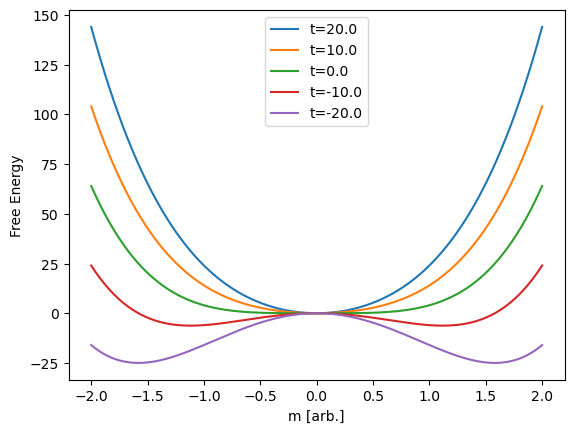

In [250]:
m = LinRange(-2.0, 2.0, 300)
ts = [20.0, 10.0, 0.0, -10.0, -20.0]
u = 4.0
for t in ts
    E = t*m.^2 + u*m.^4
    plot(m, E, label="t=$(t)")
end
xlabel("m [arb.]")
ylabel("Free Energy")
legend()
PyPlot.display_figs()

In [88]:
seed = 24
λrelfnc(t) = 0.9*smoothstep(t/200.)
κ=2π*30 #MHz
Nspin=10
tmax=2000

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrelfnc, κ=κ, tmax=tmax, Nspin=Nspin)

Running with seed: 24

([0.0, 0.40008001600320064, 0.8001600320064013, 1.2002400480096018, 1.6003200640128026, 2.000400080016003, 2.4004800960192036, 2.8005601120224046, 3.200640128025605, 3.6007201440288057  …  1996.3992798559711, 1996.7993598719745, 1997.1994398879776, 1997.5995199039808, 1997.999599919984, 1998.3996799359873, 1998.7997599519904, 1999.1998399679935, 1999.5999199839969, 2000.0], Ket{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{5//1, Int64}, FockBasis{Int64}}}, Vector{ComplexF64}}[Ket(dim=55)
  basis: [Spin(5) ⊗ Fock(cutoff=4)]
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=55)
  basis: [Spin(5) ⊗ Fock(cutoff=4)]
             0.0 - 0.0im
            -0.0 - 0.0im
            -0.0 - 0.0im
            -0.0 + 0.0im
             0.0 + 0.0im
             0.0 - 0.0im
             0.0 -

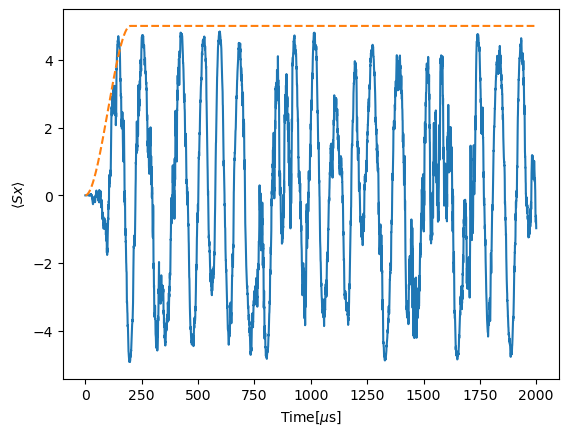

In [102]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

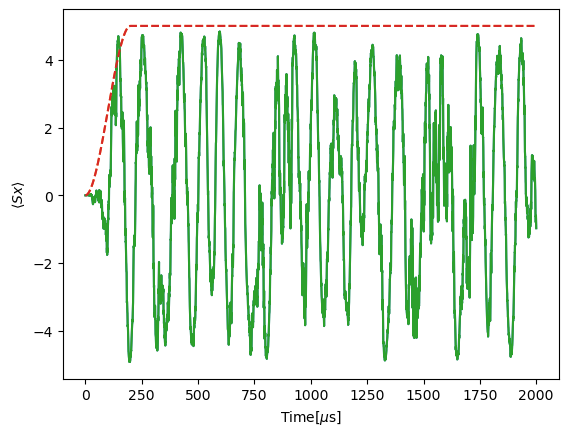

In [110]:
ax = gca()
ax.plot(tout, expect(Sx, psi_t))
ax.plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
ax.set_xlabel("Time[\$\\mu\$s]")
ax.set_ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

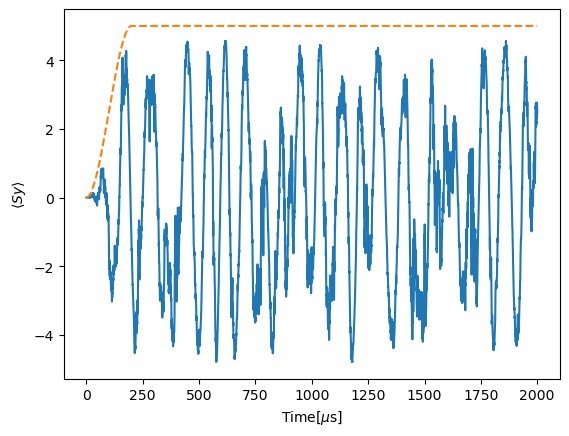

In [103]:
plot(tout, expect(Sy, psi_t))
plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sy \\rangle\$")
PyPlot.display_figs()

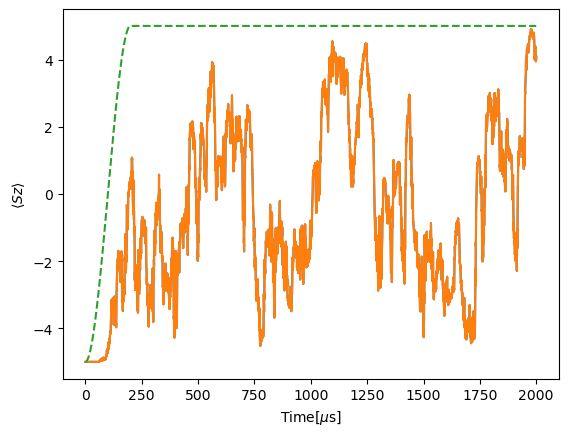

In [99]:
plot(tout, expect(Sz, psi_t))
plot(tout, 10/0.9*λrelfnc.(tout).-5, linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sz \\rangle\$")
PyPlot.display_figs()

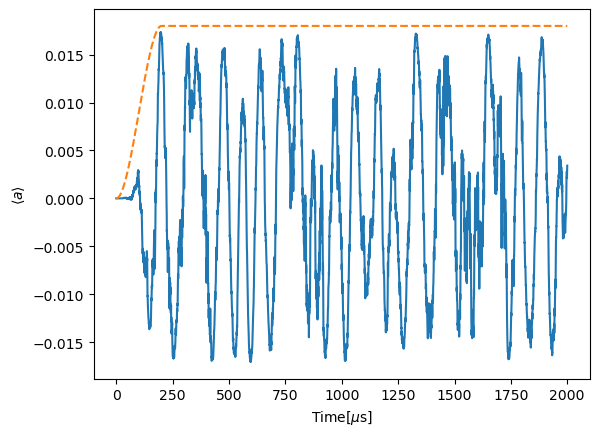

In [100]:
plot(tout, expect(a, psi_t))
plot(tout, 0.02*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

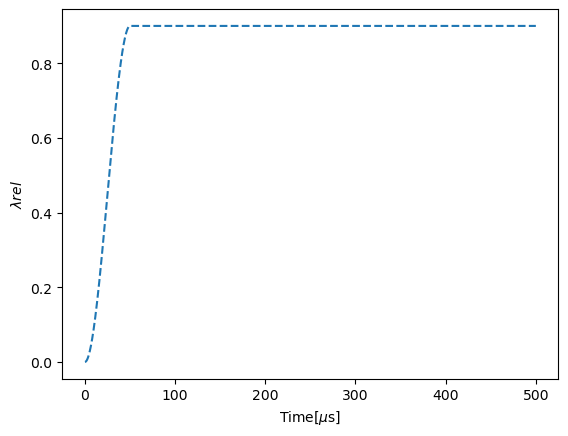

In [81]:
plot(tout, λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\lambda rel\$")
PyPlot.display_figs()

In [44]:
expect(Sz, psi_t)[1]

-50.0 + 0.0im

In [19]:
tout = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "tout");
psi_t = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "psi_t");
W = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "W");

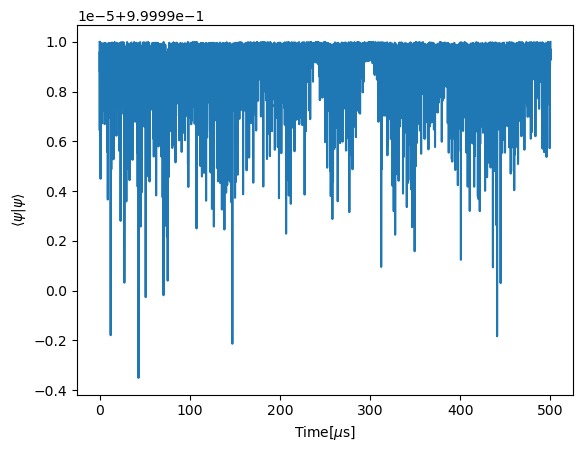

In [47]:
fb, sb, bases, a, Sx, Sy, Sz, idOp = make_operators(4, 100)
plot(tout, expect(idOp, psi_t))
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle \\psi | \\psi \\rangle\$")
PyPlot.display_figs()

In [37]:
W(0.1)

(0.2384303867108135 - 0.3203593358009233im, -0.8781749128519063 - 0.20590953906942272im)

In [ ]:
white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

In [11]:
seed = 26
λrel = 1.0
κ=200.0

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrel, κ=κ, tmax=500.0, Nspin=100);

Running with seed: 24

In [8]:
seed = 24
λrels = LinRange(0.0, 3.0, 30)
λrel = λrels[25]
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");

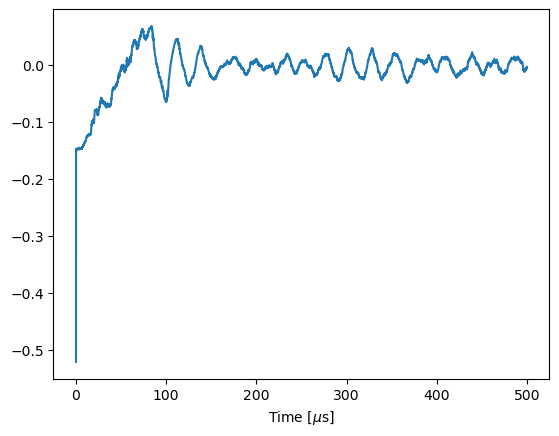

In [14]:
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)
plot(tout, expect(a, psi_t))
xlabel("Time [\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

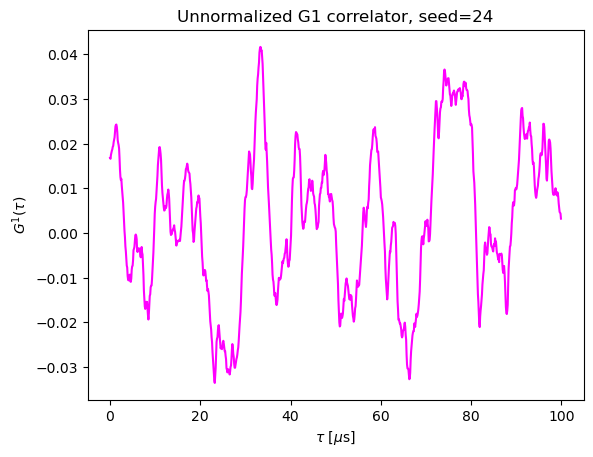

In [13]:
# seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 24
λrels = LinRange(0.0, 3.0, 30)
# short_list = λrels[1:7]
cm = get_cmap(:spring)
κ=200.0
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)

for λrel in λrels[1:1]
    tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
    psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
    W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");


    white_noise = zeros(ComplexF64, length(tout))
    prev_index = 1
    new_index = 1
    for i = 2:length(tout)
        new_index = prev_index
        while W.t[new_index] < tout[i]
            new_index += 1
        end
        white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
        prev_index = new_index
    end

    Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
    dt = tout[2] - tout[1]
    tau = dt*10
    Jhetfilt = exp_filter(Jhet, tau, dt)
    time_bins = 1000
    time = tout[1:time_bins]

    Background = exp.(-time/tau)/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))

    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins))#  - Background
    # plot(time, Background)
    plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - Background, color=cm(λrel/λrels[end]), label="$(round(λrel,digits=2))")
    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
end
# legend()
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$G^1 (\tau)$")
# PyPlot.colorbar()
PyPlot.title("Unnormalized G1 correlator, seed=$(seed)")
PyPlot.display_figs()

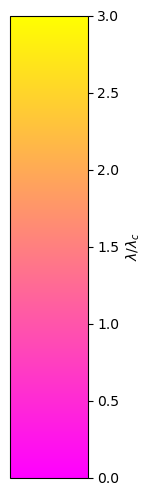

In [25]:
fig, ax = PyPlot.subplots(figsize=(1,6))
cm = get_cmap(:spring)
norm = matplotlib[:colors][:Normalize](vmin=0.0, vmax=3.0)
cb1 = matplotlib[:colorbar][:ColorbarBase](ax, cmap=cm, norm=norm)
cb1.set_label("\$\\lambda/\\lambda_c\$")
PyPlot.display_figs()

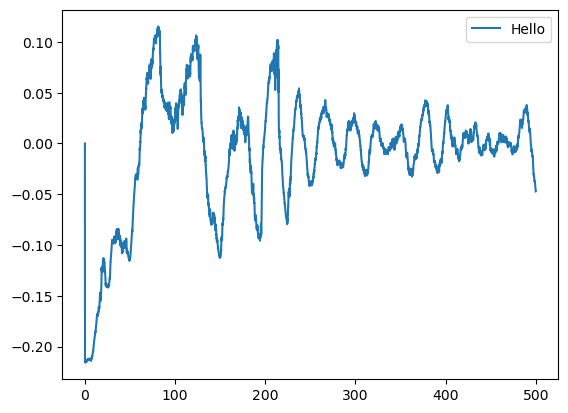

In [53]:
plot(tout, imag.(expect(a, psi_t)), label="Hello")
legend()
PyPlot.display_figs()

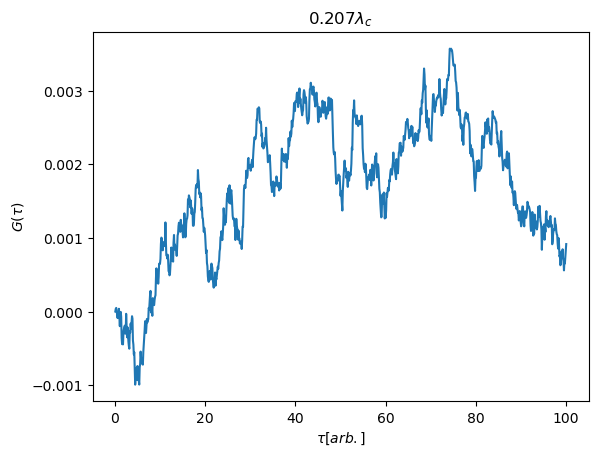

In [27]:
seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 42
λrel = 0.207
κ=200.0
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "W");

white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
dt = tout[2] - tout[1]
tau = dt*1000
time_bins = 1000
time = dt*collect(1:time_bins)

Background = zeros(length(time))
Background[1] = 1/dt

# plot(time, two_point_correlator(Jhet, tout, dt, time_bins))#  - Background
# plot(time, Background)
plot(time, exp_filter(two_point_correlator(Jhet, tout, dt, time_bins) - Background, tau, dt))
# plot(time, two_point_correlator(Jhet, tout, dt, time_bins) - two_point_correlator(conj(white_noise), tout, dt, time_bins))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.title("$(λrel)\$\\lambda_c\$")
PyPlot.display_figs()

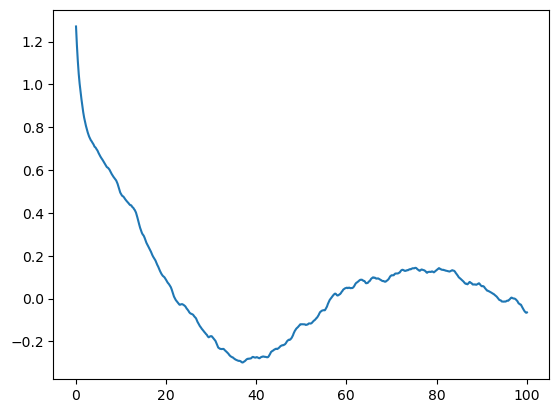

In [23]:
plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
PyPlot.display_figs()

In [70]:
two_point_correlator(Jhetfilt, tout, dt, 300)[2]

0.5062638157327481 + 0.00455229561347181im

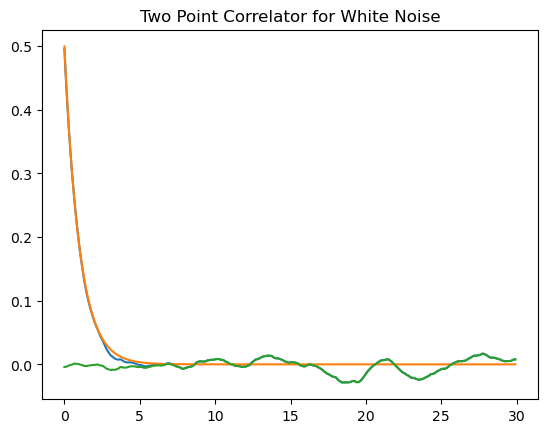

Pre-factor Actual: 0.49013553410966115-0.5106688003821964 	 Expected: 0.49953379120384234
 Decay time: 0.9883958362112918-1.050598005985766 	 Expected: 0.9999000000000001


In [10]:
W = WienerProcess(0.,im*0., im*0.)
time_total = LinRange(0.0,1000.0,10000)
time = time_total[1:300]
dt = time[2] - time[1]
tau = 10*dt
noise = make_white_noise(time_total, W)
filt_noise = exp_filter(noise, tau, dt)
Background = exp.(-time/tau)/dt*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))
Bin_var = 1/dt

two_point = real.(two_point_correlator(filt_noise, time_total, dt, 300))

@. model(x,p) = p[1]*exp(-x*p[2])
fit = curve_fit(model, time,two_point, [1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)), 1/tau])

Background = exp.(-time/tau)*(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))

rslt = confidence_interval(fit, 0.1)
println("Pre-factor Actual: $(rslt[1][1])-$(rslt[1][2]) \t Expected: $(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))\n Decay time: $(rslt[2][1])-$(rslt[2][2]) \t Expected: $(1/tau)")

# plot(time[1:300], two_point_correlator(noise, time, dt, 300))#  - Background
plot(time, two_point_correlator(filt_noise, time_total, dt, 300))
plot(time, Background)
# plot(time, two_point_correlator(noise, time_total, dt, 300))
# plot(time, Bin_var*ones(length(time)))
plot(time, two_point_correlator(filt_noise, time_total, dt, 300)-Background)
PyPlot.title("Two Point Correlator for White Noise")
PyPlot.display_figs()